##Importing Libraries


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA 
import numpy as np
from keras.layers import Input,concatenate,LSTM,Dense
from keras.models import Model
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt




##Loading Dataset

In [0]:
data=pd.read_csv("musk_csv.csv")

In [0]:
data.shape

(6598, 170)

In [0]:
data.head()

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1


### Unique Class in Dataset

In [0]:
data["class"].unique()

array([1, 0])

In [0]:
data.dtypes

ID                    int64
molecule_name        object
conformation_name    object
f1                    int64
f2                    int64
                      ...  
f163                  int64
f164                  int64
f165                  int64
f166                  int64
class                 int64
Length: 170, dtype: object

In [0]:
data.describe()

,ID,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
count,6598.00000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,...,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000,6598.000000
mean,3299.50000,58.945135,-119.128524,-73.146560,-0.628372,-103.533495,18.359806,-14.108821,-1.858290,-86.003031,-44.495756,-119.456502,-84.929221,-61.911185,-127.935283,-123.005153,-265.690967,-53.415732,-67.741285,-52.352531,-44.902698,-75.645953,-55.783419,-61.619127,72.506062,32.285238,-69.659139,-15.361018,-102.665959,8.520764,12.553956,-82.314186,25.436193,-34.503183,-78.915732,-73.199000,115.882995,-115.562746,-7.853289,-75.578509,...,-19.476811,-68.070627,-94.963474,2.993786,-36.652774,-79.191422,-90.778266,-95.868142,-28.259473,-8.521067,-37.599121,-67.789330,-51.976508,-65.693089,-0.443165,1.331464,-21.754319,-165.748863,-87.364050,-113.114580,-18.523644,-41.386481,8.755077,-55.026069,-61.105335,-54.810397,-76.831161,33.209912,-61.212337,-210.975447,-184.798272,-75.795696,-26.073204,64.616702,112.037739,201.760230,-47.488330,-150.259927,41.770233,0.154138
std,1904.82287,53.249007,90.813375,67.956235,80.444617,64.387559,80.593655,115.315673,90.372537,108.326676,72.088903,108.911397,79.541410,61.444281,101.191126,98.009158,70.647329,117.237608,61.403085,82.503477,79.304489,75.187995,101.908604,94.524709,123.334433,108.105908,101.325550,91.621335,73.778232,63.484770,126.086157,80.225924,106.627993,57.816952,118.201270,75.350809,57.070192,104.682519,85.732778,70.534415,...,130.607205,70.016546,98.100733,60.633027,84.316386,61.733776,68.098995,87.253395,61.664300,97.997434,77.580190,94.753428,64.344336,69.094605,82.410293,103.746483,103.113954,54.087579,51.177725,21.463582,63.048333,73.864481,83.274158,60.100098,70.788743,67.538140,76.908685,98.511502,97.547356,83.710890,107.819514,127.861271,69.727964,100.861935,72.835040,59.526751,55.069365,76.019023,94.116085,0.361108
min,1.00000,-31.000000,-199.000000,-167.000000,-114.000000,-118.000000,-183.000000,-171.000000,-225.000000,-245.000000,-286.000000,-328.000000,-321.000000,-305.000000,-342.000000,-294.000000,-327.000000,-224.000000,-308.000000,-286.000000,-252.000000,-295.000000,-185.000000,-253.000000,-76.000000,-100.000000,-242.000000,-205.000000,-166.000000,-142.000000,-162.000000,-117.000000,-143.000000,-139.000000,-279.000000,-160.000000,-7.000000,-175.000000,-190.000000,-148.000000,...,-221.000000,-307.000000,-189.000000,-123.000000,-140.000000,-319.000000,-338.000000,-336.000000,-196.000000,-197.000000,-199.000000,-243.000000,-283.000000,-290.000000,-185.000000,-157.000000,-171.000000,-179.000000,-106.000000,-136.000000,-200.000000,-213.000000,-190.000000,-140.000000,-128.000000,-114.000000,-173.000000,-143.000000,-198.000000,-257.000000,-328.000000,-219.000000,-136.000000,-120.000000,-69.000000,73.000000,-289.000000,-428.000000,-471.000000,0.000000
25%,1650.25000,3

## Removing the Unnecessary Columns

In [0]:
data.drop(["ID","molecule_name","conformation_name"],axis=1,inplace=True)

In [0]:
data.shape

(6598, 167)

In [0]:
data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,40,-27,68,...,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96,1
1,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,2,-144,38,...,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79,1
2,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,3,-129,37,...,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39,1
3,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,3,-144,38,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80,1
4,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,3,-144,38,...,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80,1


## Spliting Data and Target (x and y)

In [0]:
x=data.drop("class",axis=1)
y=data["class"]

In [0]:
x.shape,y.shape

((6598, 166), (6598,))

In [0]:
x.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32,f33,f34,f35,f36,f37,f38,f39,f40,...,f127,f128,f129,f130,f131,f132,f133,f134,f135,f136,f137,f138,f139,f140,f141,f142,f143,f144,f145,f146,f147,f148,f149,f150,f151,f152,f153,f154,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164,f165,f166
0,46,-108,-60,-69,-117,49,38,-161,-8,5,-323,-220,-113,-299,-283,-307,-31,-106,-227,-42,-59,-22,-67,189,81,17,-27,-89,-67,105,-116,124,-106,5,-120,63,-165,40,-27,68,...,-27,81,-114,-187,45,-118,-75,-182,-234,-19,12,-13,-41,-119,-149,70,17,-20,-177,-101,-116,-14,-50,24,-81,-125,-114,-44,128,3,-244,-308,52,-7,39,126,156,-50,-112,96
1,41,-188,-145,22,-117,-6,57,-171,-39,-100,-319,-111,-228,-281,-281,-300,54,-149,-98,-196,-27,-22,2,75,49,-34,45,-91,32,95,-116,85,-23,42,-58,61,-171,2,-144,38,...,17,88,-21,-32,32,-128,-72,-124,-218,-94,53,-79,-20,-35,-26,4,50,17,-177,-102,-121,-66,-77,51,-41,-34,-32,-63,115,-5,-235,-59,-2,52,103,136,169,-61,-136,79
2,46,-194,-145,28,-117,73,57,-168,-39,-22,-319,-111,-104,-283,-282,-303,52,-152,-97,-225,-28,-22,2,179,49,-33,46,-88,22,79,-116,19,-11,6,-38,71,-175,3,-129,37,...,41,64,0,-23,-15,-129,-74,-125,-221,-93,53,-72,-19,-33,-26,3,49,17,-177,-102,-119,-66,-81,51,-41,-27,-41,-140,77,-163,-238,-134,-154,57,143,142,165,-67,-145,39
3,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,77,48,-34,46,-91,32,94,-116,84,-23,41,-58,62,-171,3,-144,38,...,17,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-77,52,-41,-34,-32,-66,115,-7,-236,-60,-4,52,104,136,168,-60,-135,80
4,41,-188,-145,22,-117,-7,57,-170,-39,-99,-319,-111,-228,-282,-281,-301,54,-150,-98,-196,-28,-22,2,78,48,-34,46,-91,31,94,-116,84,-23,41,-58,62,-171,3,-144,38,...,17,88,-20,-32,32,-128,-73,-125,-220,-93,53,-78,-19,-34,-26,4,50,17,-177,-101,-121,-65,-76,52,-41,-34,-32,-66,115,-8,-236,-60,-4,52,104,137,168,-60,-135,80


## Spliting Train and Test Data

In [0]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=4,stratify=y)

In [0]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((5278, 166), (5278,), (1320, 166), (1320,))

### The Dataset contains features from f1 to f166
> Features from f1 to f162 are the distance Meansure (Non-seq)

> Features f163, f164, f165, f166 are the 3-Space Co-ordinaate (seq)

### So splliting the Normal and 3-D Data, so i can handle both seperately

In [0]:
x_non_seq_train = x_train.iloc[:,:162]
x_seq_train = x_train.iloc[:,162:]

x_non_seq_test = x_test.iloc[:,:162]
x_seq_test = x_test.iloc[:,162:]

## Scaling the Distance Features (Non-seq)

In [0]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 

In [0]:
print(x_seq_train.shape)
print(x_non_seq_train.shape)
print(x_seq_test.shape)
print(x_non_seq_test.shape)

(5278, 4)
(5278, 162)
(1320, 4)
(1320, 162)


In [0]:
sc.fit(x_non_seq_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
x_non_seq_train=sc.transform(x_non_seq_train)
x_non_seq_test=sc.transform(x_non_seq_test)

## As the dimension of Distance features are very large, so we can reduce that by using PCA

In [0]:
pca=PCA()

In [0]:
pca.fit(x_non_seq_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
print(np.cumsum((pca.explained_variance_ratio_)))


[0.29975468 0.48015878 0.52932522 0.57366232 0.6084202  0.64000075
 0.66888761 0.69495775 0.71931478 0.7418363  0.76088437 0.77898498
 0.79465514 0.80955565 0.82227768 0.83493188 0.84584421 0.85612397
 0.86496165 0.87332978 0.88040513 0.88700223 0.89346006 0.89972182
 0.90563468 0.91118605 0.91633883 0.92097806 0.92551984 0.92974209
 0.93363391 0.9372676  0.9407305  0.94386689 0.94676542 0.94956324
 0.95220359 0.95466063 0.95696614 0.95923299 0.96119551 0.96299176
 0.96473823 0.96646331 0.96808181 0.96962936 0.9710942  0.97247019
 0.97370315 0.97485123 0.97595223 0.97702616 0.97804829 0.97900524
 0.97992524 0.98080548 0.98163986 0.98244731 0.98318311 0.98389992
 0.98459467 0.9852764  0.9859329  0.98656563 0.98718367 0.98776941
 0.98833566 0.98886501 0.98935626 0.98983234 0.99028372 0.99071416
 0.99113558 0.99152544 0.99190337 0.9922664  0.99262385 0.99296927
 0.99330042 0.99360552 0.99388582 0.99414843 0.99440897 0.99465257
 0.99487557 0.99509325 0.99530388 0.99550077 0.99569336 0.9958

## As it clear from above output, around 98% variance is explained by 56 component by PCA

In [0]:
pca=PCA(56)

### Fitting the PCA on training and transforming on both train and test data

In [0]:
pca.fit(x_non_seq_train)
x_non_seq_train=pca.transform(x_non_seq_train)
x_non_seq_test=pca.transform(x_non_seq_test)

### Confirming the shape after applying PCA

In [0]:
x_non_seq_train.shape,x_non_seq_test.shape

((5278, 56), (1320, 56))

## Function to create a Data for 3-D data (seq) so that it can be used in Sequence Models

In [0]:
def load_signals(subset):
    signal_data = []

    for col in subset.columns:
        res=subset[col].as_matrix()
        res=res.reshape(-1,1)
        signal_data.append(res)
    return np.transpose(signal_data, (1, 2, 0))

### Shape before Transformation

In [0]:
x_seq_train.shape,x_seq_test.shape

((5278, 4), (1320, 4))

### Using Load_signals function

In [0]:
x_seq_train=load_signals(x_seq_train)
x_seq_test=load_signals(x_seq_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


### After Transformation 

In [0]:
x_seq_train.shape,x_seq_test.shape

((5278, 1, 4), (1320, 1, 4))

In [0]:
x_seq_train[0][0]

array([ 177,  -42, -116,  126])

## The Data is Imbalanced

In [0]:
y.value_counts()

0    5581
1    1017
Name: class, dtype: int64

In [0]:
np.unique(y_train)

array([0, 1])

## Calculating the weights of class

In [0]:
from sklearn.utils import class_weight
class_weight=class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)


In [0]:
class_weight

array([0.59117384, 3.24201474])

In [0]:
print(x_non_seq_train.shape)
print(x_non_seq_test.shape)
print(x_seq_train.shape)
print(x_seq_test.shape)

(5278, 56)
(1320, 56)
(5278, 1, 4)
(1320, 1, 4)


# Model Architecture 

## To Handle 3-D Data(seq Data)

> auxiliary output to tune LSTM weights smoothly 


In [0]:
seq_input=Input(shape=(1,4),name="seq_input")
lstm_out=LSTM(128)(seq_input)
auxilary_output=Dense(1,activation="sigmoid",name="auxilary_output")(lstm_out)

## To Handle distance features Data

> This network will take the distance feature as a input and then Concatenate that layer with the output layer of LSTM Model

In [0]:
non_seq=Input(shape=(56,),name="non_seq")
# combined with lstm output
x=concatenate([lstm_out,non_seq])
# now the combined data is being fed to dense layers
dense1=Dense(30,activation='relu')(x)
dense2=Dense(20,activation="relu")(dense1)
main_out=Dense(1,activation="sigmoid",name="main_out")(dense2)

In [0]:
model=Model(inputs=[seq_input,non_seq],outputs=[main_out,auxilary_output])

In [0]:
model.compile(optimizer="adam",
             loss={
                 'main_out':'binary_crossentropy',
                 'auxilary_output':'binary_crossentropy'
             },
             loss_weights={'main_out':1, 'auxilary_output':1},
             metrics=["accuracy"])

## Defining Checkpoint to Save the Best Model While Training

In [0]:
from keras.callbacks import ModelCheckpoint
import os
outputFolder = './musk_model_output'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/weights-{epoch:02d}-{val_main_out_acc:.4f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_main_out_acc', verbose=1, 
                             save_best_only=True,
                             mode='auto')

In [0]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          (None, 1, 4)         0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          68096       seq_input[0][0]                  
__________________________________________________________________________________________________
non_seq (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 184)          0           lstm_8[0][0]                     
                                                                 non_seq[0][0]              

## Training Model

In [0]:
history=model.fit({'seq_input':x_seq_train,
          "non_seq":x_non_seq_train},
         {"main_out":y_train,"auxilary_output":y_train},
        validation_data=[{'seq_input': x_seq_test, 'non_seq': 
           x_non_seq_test},
          {'main_out': y_test, 'auxilary_output': y_test}],
         class_weight={0:0.59117384,1:3.24201474},
         epochs=60,batch_size=32,callbacks=[checkpoint])

Train on 5278 samples, validate on 1320 samples
Epoch 1/60
5278/5278 [==============================] - 4s 787us/step - loss: 0.6669 - main_out_loss: 0.2945 - auxilary_output_loss: 0.3724 - main_out_acc: 0.8763 - auxilary_output_acc: 0.8405 - val_loss: 0.5431 - val_main_out_loss: 0.1926 - val_auxilary_output_loss: 0.3505 - val_main_out_acc: 0.9273 - val_auxilary_output_acc: 0.8439

Epoch 00001: val_main_out_acc improved from -inf to 0.92727, saving model to ./musk_model_output/weights-01-0.9273.h5
Epoch 2/60
5278/5278 [==============================] - 2s 401us/step - loss: 0.4878 - main_out_loss: 0.1526 - auxilary_output_loss: 0.3352 - main_out_acc: 0.9437 - auxilary_output_acc: 0.8621 - val_loss: 0.4639 - val_main_out_loss: 0.1284 - val_auxilary_output_loss: 0.3355 - val_main_out_acc: 0.9477 - val_auxilary_output_acc: 0.8500

Epoch 00002: val_main_out_acc improved from 0.92727 to 0.94773, saving model to ./musk_model_output/weights-02-0.9477.h5
Epoch 3/60
5278/5278 [=================

In [0]:
print(history.history.keys())
# summarize history for accuracy


dict_keys(['val_loss', 'val_main_out_loss', 'val_auxilary_output_loss', 'val_main_out_acc', 'val_auxilary_output_acc', 'loss', 'main_out_loss', 'auxilary_output_loss', 'main_out_acc', 'auxilary_output_acc'])


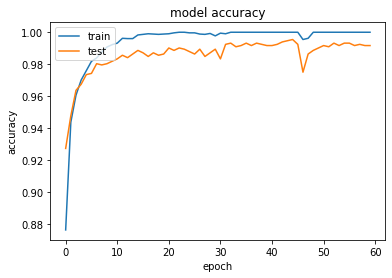

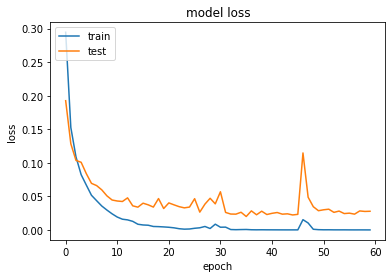

In [0]:
plt.plot(history.history['main_out_acc'])
plt.plot(history.history['val_main_out_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['main_out_loss'])
plt.plot(history.history['val_main_out_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from keras.models import load_model
check=load_model("/content/musk_model_output/weights-45-0.9955.h5")

In [251]:
check.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_input (InputLayer)          (None, 1, 4)         0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          68096       seq_input[0][0]                  
__________________________________________________________________________________________________
non_seq (InputLayer)            (None, 56)           0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 184)          0           lstm_8[0][0]                     
                                                                 non_seq[0][0]              

In [0]:
from sklearn.metrics import precision_score,recall_score,f1_score,log_loss

In [0]:
pred=check.predict(x={'seq_input': x_seq_test, 'non_seq': 
          x_non_seq_test})

# Model Evaluation

In [276]:
evaluate=check.evaluate(x={'seq_input': x_seq_test, 'non_seq': 
          x_non_seq_test},y={'main_out': y_test, 'auxilary_output': 
          y_test})

1320/1320 [==============================] - 1s 872us/step


>evaluate[0]----val_loss

>evaluate[1]----val_main_out_loss (Main Loss)

>evaluate[2]----val_auxilary_output_loss

>evaluate[3]----val_main_out_acc

>evaluate[3]----val_auxilary_output_acc



## The loss is around 0.022 for **main_out** layer output

In [287]:
evaluate[1]

0.022360007547577727

### The  Accuracy is 99.5% from ***main_out***

In [268]:
accuracy_score(y_test,pred[0].round()) *100

99.54545454545455

### precision_score is 99% from ***main_out***

In [270]:
precision_score(y_test,pred[0].round())*100

99.00497512437812

### recall_score is 98% from ***main_out***

In [271]:
recall_score(y_test,pred[0].round())*100

98.0295566502463

### f1_score is 98.5% from ***main_out***

In [272]:
f1_score(y_test,pred[0].round())*100

98.51485148514853